# SP 500 Index Forecast

## Load Data

In [1]:
import pandas as pd
import numpy as np

DATA_PATH = "sp500_training.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
ticker = "^GSPC" # only train on index data
df = df[df["Ticker"] == ticker]
df = df.drop(columns=["Ticker"])
df = df.sort_values(by=["Date"])

In [2]:
df.head()

,Date,Open,High,Low,Close,Volume,Return
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,NaN
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,-0.038345
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.001922
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.000956
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.027090


## Feature Engineering

In [3]:
SHIFT = 1 # options: 1, 5, 21

def calculate_new_features(df):
    df['Quarter'] = df['Date'].dt.quarter
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month

    df.set_index('Date', inplace=True)

    df["Quarter.X"], df["Quarter.Y"] = np.sin(2 * np.pi * df["Quarter"] / 4), np.cos(2 * np.pi * df["Quarter"] / 4)
    df["Month.X"], df["Month.Y"] = np.sin(2 * np.pi * df["Month"] / 12), np.cos(2 * np.pi * df["Month"] / 12)
    df["Year.X"], df["Year.Y"] = np.sin(2 * np.pi * df.index.day_of_year / 365), np.cos(2 * np.pi * df.index.day_of_year / 365)

    df['MA_5'] = df['Close'].rolling(5).mean()
    df['MA_21'] = df['Close'].rolling(21).mean()
    df['Volatility_5'] = df['Close'].rolling(5).std()
    df['Volatility_21'] = df['Close'].rolling(21).std()
    df['Target'] = df['Close'].shift(-SHIFT)
    df['Lag_1'] = df['Close'].shift(1)
    df['Lag_5'] = df['Close'].shift(5)
    df['Lag_21'] = df['Close'].shift(21)

    # Drop rows with NaNs from rolling/lags
    df.dropna(inplace=True)
    df = df.drop(["Quarter", "Year", "Month"], axis=1)
    return df

df = calculate_new_features(df)
df.head()

,Open,High,Low,Close,Volume,Return,Quarter.X,Quarter.Y,Month.X,Month.Y,Year.X,Year.Y,MA_5,MA_21,Volatility_5,Volatility_21,Target,Lag_1,Lag_5,Lag_21
Date,,,,,,,,,,,,,,,,,,,,
2000-02-02,1409.280029,1420.609985,1403.489990,1409.119995,1038600000,-0.000114,1.0,6.123234e-17,0.866025,0.5,0.538005,0.842942,1394.316016,1422.613816,20.172650,27.763426,1424.969971,1409.280029,1404.089966,1455.219971
2000-02-03,1409.119995,1425.780029,1398.520020,1424.969971,1146500000,0.011248,1.0,6.123234e-17,0.866025,0.5,0.552435,0.833556,1399.597998,1423.830479,24.545364,27.251304,1424.369995,1409.119995,1398.560059,1399.420044
2000-02-04,1424.969971,1435.910034,1420.630005,1424.369995,1045100000,-0.000421,1.0,6.123234e-17,0.866025,0.5,0.566702,0.823923,1412.439990,1424.890480,12.684780,26.793270,1424.239990,1424.969971,1360.160034,1402.109985
2000-02-07,1424.369995,1427.150024,1413.329956,1424.239990,918100000,-0.000091,1.0,6.123234e-17,0.866025,0.5,0.608477,0.793572,1418.395996,1425.880482,8.399451,26.341727,1441.719971,1424.369995,1394.459961,1403.449951
2000-02-08,1424.239990,1441.829956,1424.239990,1441.719971,1047700000,0.012273,1.0,6.123234e-17,0.866025,0.5,0.622047,0.782980,1424.883984,1425.892386,11.539498,26.349180,1411.709961,1424.239990,1409.280029,1441.469971


## Exploratory Data Analysis

In [4]:
print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
print(f"Years covered: {df.index.year.unique()}")
print()
# print(df.info())
print(df.describe().T)

Date range: 2000-02-02 to 2025-05-15
Years covered: Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
       2024, 2025],
      dtype='int32', name='Date')

                count          mean           std           min           25%  \
Open           6360.0  2.166646e+03  1.310097e+03  6.792800e+02  1.203622e+03   
High           6360.0  2.179244e+03  1.316611e+03  6.952700e+02  1.210460e+03   
Low            6360.0  2.153121e+03  1.303184e+03  6.667900e+02  1.196103e+03   
Close          6360.0  2.166986e+03  1.310396e+03  6.765300e+02  1.203645e+03   
Volume         6360.0  3.383616e+09  1.496595e+09  3.560700e+08  2.282352e+09   
Return         6360.0  3.012013e-04  1.228654e-02 -1.198406e-01 -4.798753e-03   
Quarter.X      6360.0 -2.358491e-03  7.050427e-01 -1.000000e+00 -2.449294e-16   
Quarter.Y      6360.0 -3.301887e-03  7.092641e-01 -1.000000e+00 -1.000000e+00   
Month.

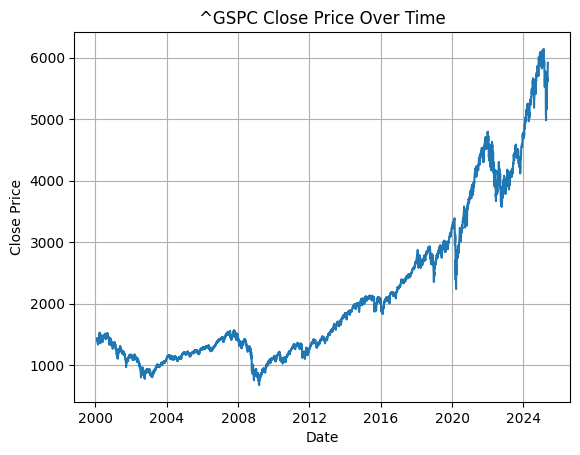

In [5]:
import matplotlib.pyplot as plt

plt.plot(df.index, df["Close"])
plt.title(f"{ticker} Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

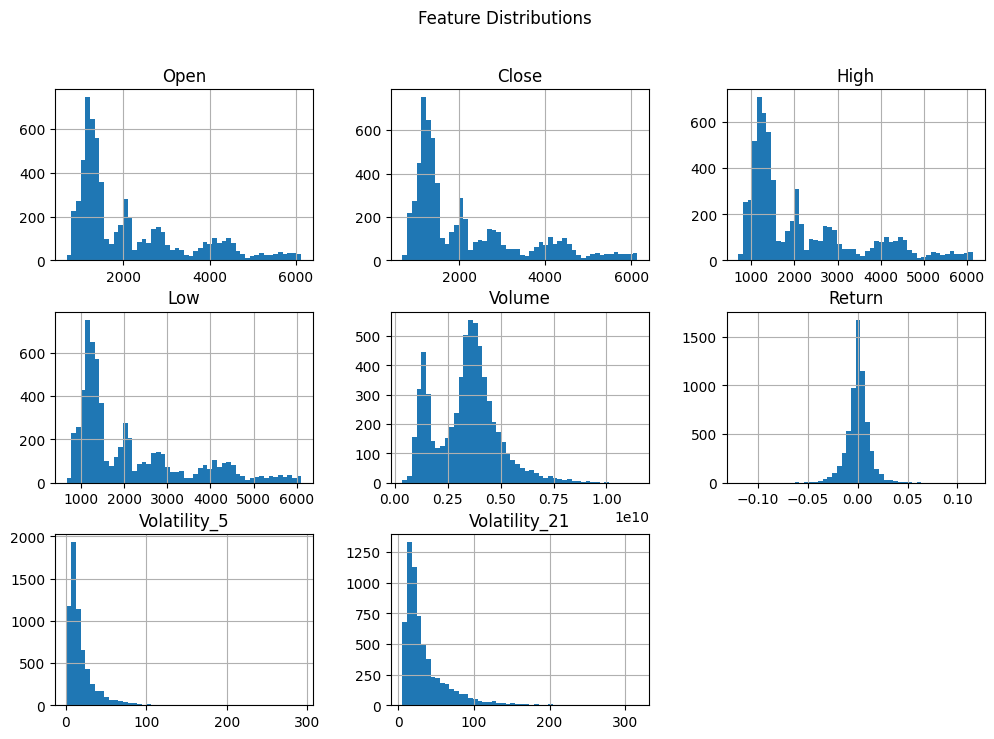

In [6]:
df[['Open', 'Close' ,'High' , 'Low', 'Volume', 'Return', 'Volatility_5', 'Volatility_21']].hist(bins=50, figsize=(12, 8))
plt.suptitle("Feature Distributions")
plt.show()

## SARIMA

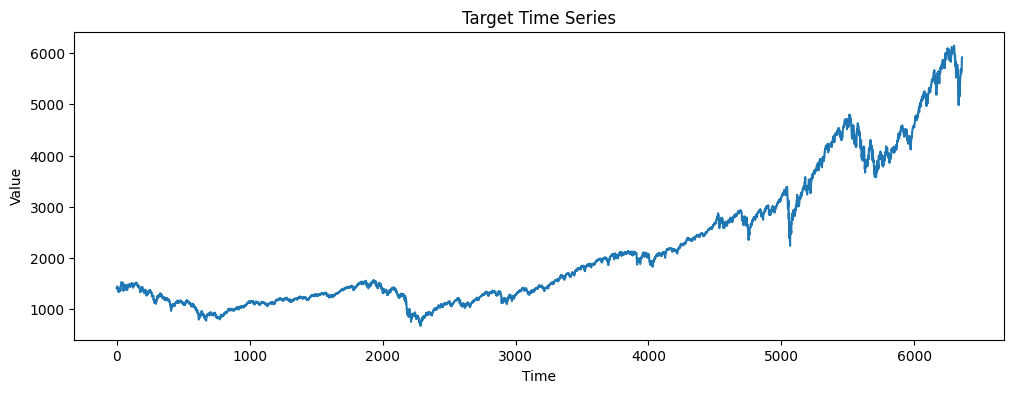

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

target_series = pd.DataFrame(df["Close"].values)

plt.figure(figsize=(12, 4))
plt.plot(target_series)
plt.title("Target Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [8]:
train_size = int(len(target_series) * 0.5)
msk = target_series.index < train_size
train_df, test_df = target_series[msk].copy(), target_series[~msk].copy()

ADF Statistic: -1.787515236084118
p-value: 0.38667741132365663
❌ The series is not stationary.
ADF Statistic: -12.372307519321971
p-value: 5.248045092523505e-23
✅ The series is stationary.


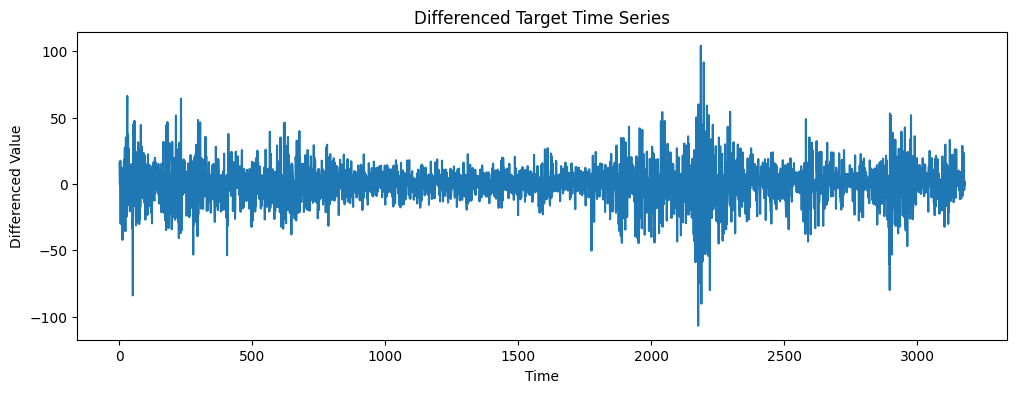

In [9]:
def stat_test(target_series):
    adf_result = adfuller(target_series)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")

    if adf_result[1] < 0.05:
        print("✅ The series is stationary.")
    else:
        print("❌ The series is not stationary.")

stat_test(train_df)

diff_series = train_df.diff().dropna()
stat_test(diff_series)

plt.figure(figsize=(12, 4))
plt.plot(diff_series)
plt.title("Differenced Target Time Series")
plt.xlabel("Time")
plt.ylabel("Differenced Value")
plt.show()

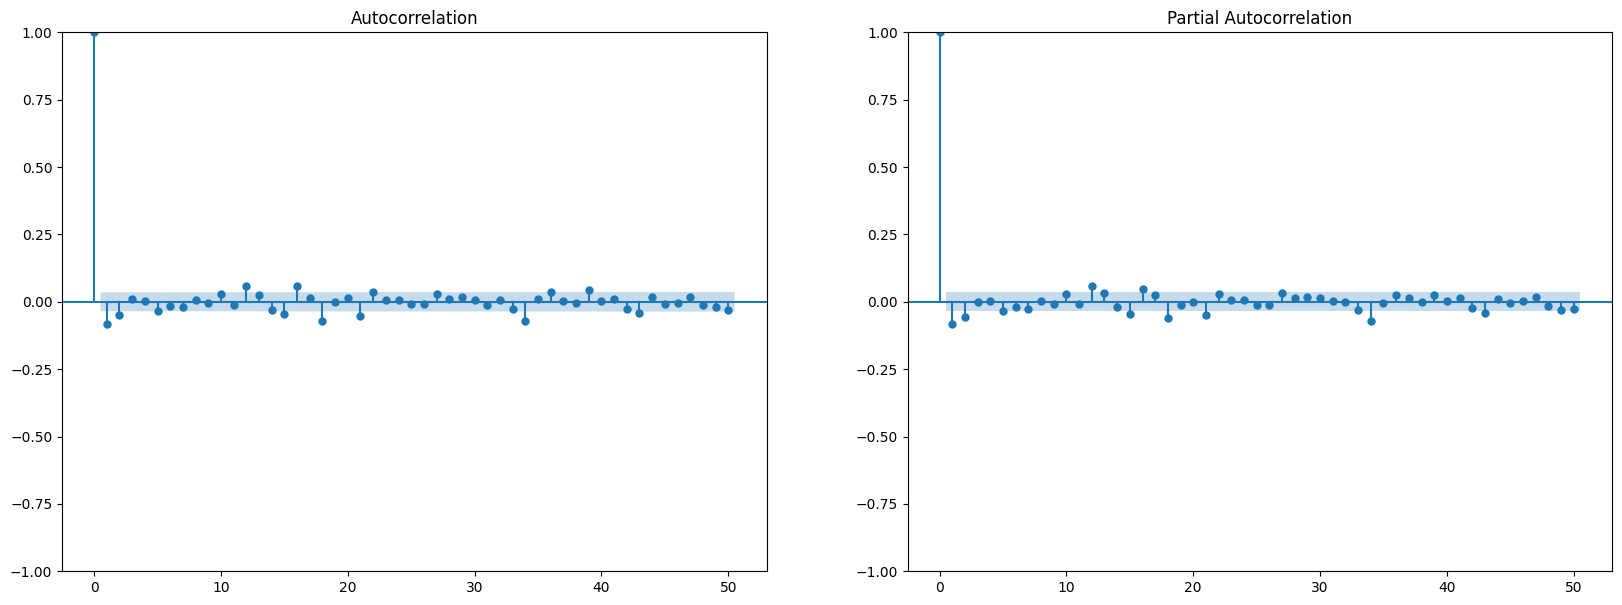

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
plot_acf(diff_series, ax=axes[0], lags=50)
plot_pacf(diff_series, ax=axes[1], lags=50)
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: display. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


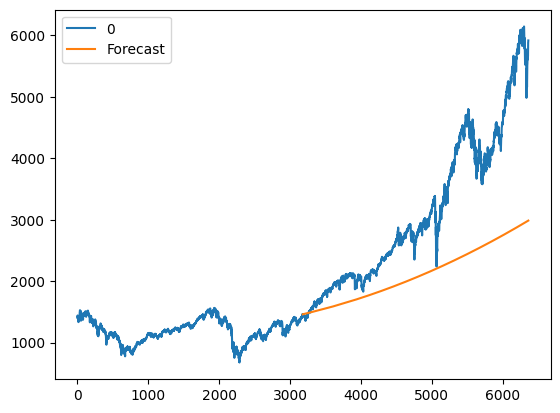

In [11]:
model = SARIMAX(
    train_df,
    order=(10, 1, 10),
    trend="ct",
    seasonal_order=(0, 0, 0, 21),
    enforce_stationarity=False,
    enforce_invertibility=False
)

trained_model = model.fit(display=False)

y_pred = trained_model.forecast(len(test_df))

target_series["Forecast"] = [None]*len(train_df) + list(y_pred)
target_series[[0, "Forecast"]].plot()
plt.show()

## Exponential Smoothing

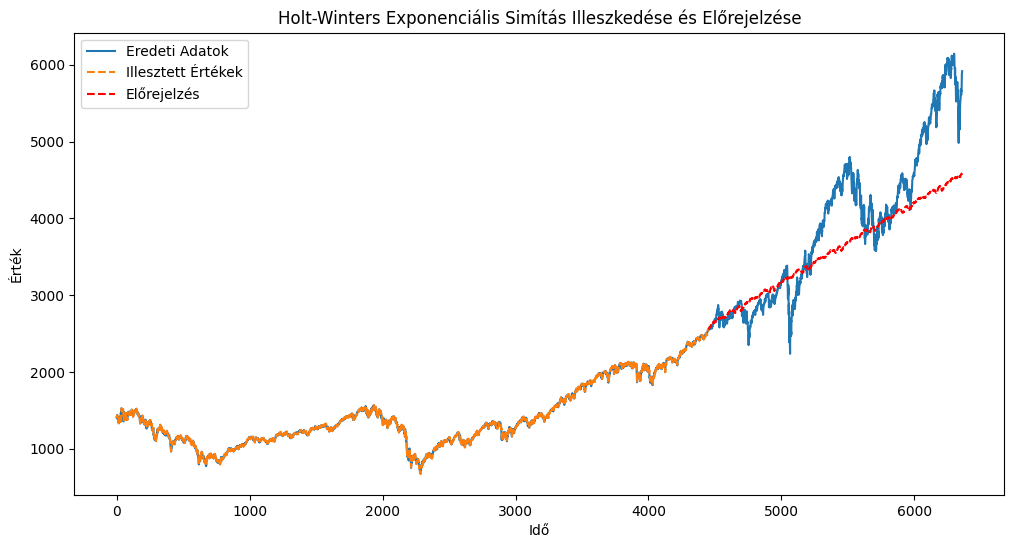

In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

series = pd.DataFrame(df["Close"].values)
train_size = int(len(df) * 0.7)
train, test = series.iloc[:train_size], series.iloc[train_size:]

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=252)
fit = model.fit()

fitted_values = fit.fittedvalues
forecast = fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label='Eredeti Adatok')
plt.plot(fitted_values.index, fitted_values, label='Illesztett Értékek', linestyle='--')
plt.plot(forecast.index, forecast, label='Előrejelzés', linestyle='--', color='red')
plt.title('Holt-Winters Exponenciális Simítás Illeszkedése és Előrejelzése')
plt.xlabel('Idő')
plt.ylabel('Érték')
plt.legend()
plt.show()

## LSTM

### Prep dataset

In [ ]:
!pip install -q scikit-learn

In [ ]:
train_start = pd.Timestamp("2000")
valid_start = pd.Timestamp("2022")
test_start = pd.Timestamp("2023")
train_df = df[(df.index >= train_start) & (df.index < valid_start)].copy()
valid_df = df[(df.index >= valid_start) & (df.index < test_start)].copy()
test_df = df[(df.index >= test_start)].copy()

In [ ]:
import pickle
from sklearn.preprocessing import StandardScaler

scaler_input = StandardScaler()
scaler_output = StandardScaler()

TARGET = "Target"

scaled_train = scaler_input.fit_transform(train_df.drop(columns=[TARGET]))
target_train = scaler_output.fit_transform(train_df[[TARGET]])
scaled_valid = scaler_input.transform(valid_df.drop(columns=[TARGET]))
target_valid = scaler_output.transform(valid_df[[TARGET]])
scaled_test = scaler_input.transform(test_df.drop(columns=[TARGET]))
target_test = scaler_output.transform(test_df[[TARGET]])

# Save
with open('scaler_input.pkl', 'wb') as f:
    pickle.dump(scaler_input, f)
with open('scaler_output.pkl', 'wb') as f:
    pickle.dump(scaler_output, f)

# Load Example
with open('scaler_input.pkl', 'rb') as f:
    scaler_input = pickle.load(f)
with open('scaler_output.pkl', 'rb') as f:
    scaler_output = pickle.load(f)

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations

def process_Xy(raw_X: np.array, raw_y: np.array, lookback: int) -> np.array:
  X = np.empty(shape=(raw_X.shape[0] - lookback, lookback , raw_X.shape[1]), dtype=np.float32)
  y = np.empty(shape=(raw_y.shape[0] - lookback), dtype=np.float32)

  target_index = 0
  for i in range(lookback, raw_X.shape[0]):
      X[target_index] = raw_X[i - lookback : i]
      y[target_index] = raw_y[i][0]
      target_index += 1

  return X.copy(), y.copy()

lookback = 10
train_X, train_y = process_Xy(scaled_train, target_train, lookback=lookback)
valid_X, valid_y = process_Xy(scaled_valid, target_valid, lookback=lookback)
test_X, test_y = process_Xy(scaled_test, target_test, lookback=lookback)

model = keras.Sequential(
    [
        layers.Input(shape=(train_X.shape[1:])),
        layers.LSTM(32, activation="relu", return_sequences=True),
        layers.LSTM(32, activation="relu"),
        layers.Dense(1),
    ]
)

model.compile(loss='MeanSquaredError', optimizer='Adam')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10, 32)         │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,009 (58.63 KB)

 Trainable params: 15,009 (58.63 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

history = model.fit(
    train_X,
    train_y,
    validation_data=(valid_X, valid_y),
    batch_size=256,
    epochs=100,
    shuffle=True,
    verbose=True,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.6782 - val_loss: 0.1564
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0512 - val_loss: 0.0818
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0177 - val_loss: 0.0716
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0131 - val_loss: 0.0712
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0107 - val_loss: 0.0686
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0099 - val_loss: 0.0665
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0089 - val_loss: 0.0662
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0095 - val_loss: 0.0650
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0089 - val_loss: 0.0795
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0079 - val_loss: 0.0832
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0074 - val_loss: 0.0794
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

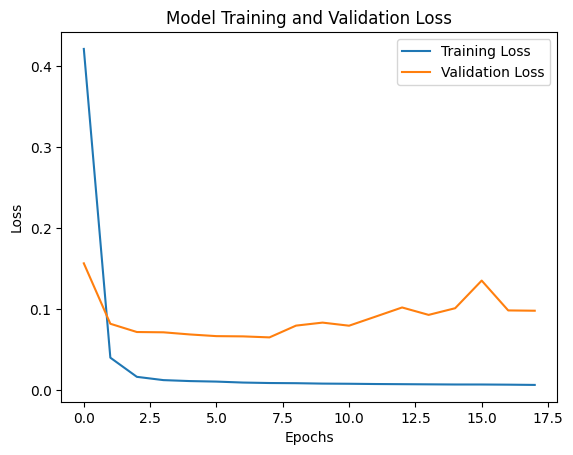

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.keras')

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


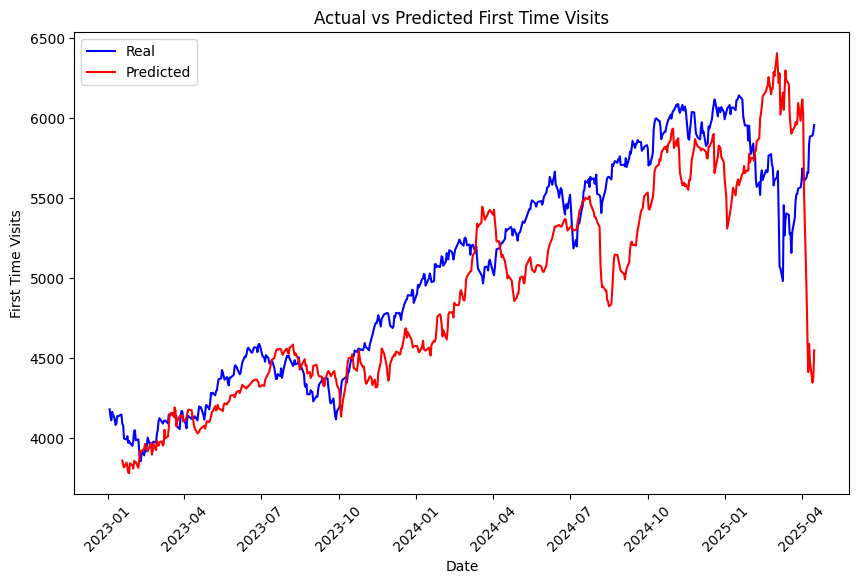

In [40]:
pred = best_model.predict(test_X)
plt.figure(figsize=(10, 6))
plt.plot(test_df[TARGET], label="Real", color='blue')
plt.plot(pd.DataFrame(index=test_df.index[lookback:], data=scaler_output.inverse_transform(pred)), label="Predicted", color='red')
plt.xticks(rotation=45)
plt.title('Actual vs Predicted First Time Visits')
plt.xlabel('Date')
plt.ylabel('First Time Visits')
plt.legend()
plt.show()